In [ ]:
import sys
sys.path.append("/root/autodl-tmp/")
from src.core.early_stop import EarlyStopping
from src.seg_unet.train_with_aug import PanNukeDataset, aug_fn, process_fn
from matplotlib import pyplot as plt
from torchvision import transforms as t
import torch
import cv2
import numpy as np
import albumentations as A

In [1]:
import yaml

def read_yaml_to_dict(yaml_path: str, ):
    with open(yaml_path) as file:
        dict_value = yaml.load(file.read(), Loader=yaml.FullLoader)
        return dict_value

In [5]:
yaml_path = "unet_config.yaml"
config = read_yaml_to_dict(yaml_path)

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
import segmentation_models_pytorch as smp

# test unet aug
测试加不加 normalize 的影响

## 积攒必要的变换

In [ ]:
transform = A.Compose([
    A.RandomCrop(512, 512),
    A.RandomBrightnessContrast(p=0.3),
    A.HorizontalFlip(p=0.5),
])

In [3]:
dataloader = PanNukeDataset(
        images_dir = '/root/autodl-tmp/datasets/consep/images/train', 
        masks_dir = '/root/autodl-tmp/datasets/consep/seg_mask/train/', 
        num_classes = 5,
        augmentation= aug_fn(), 
        preprocessing = process_fn()
        )

TypeError: __init__() takes 2 positional arguments but 3 were given

In [3]:
for image, mask, p in dataloader:
    image, mask,p = image, mask,p
    break

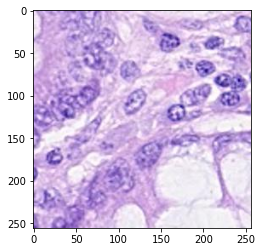

In [4]:
plt.imshow(torch.permute(image, (1,2,0)))

In [5]:
image.max()

tensor(1.)

In [6]:
image.min()

tensor(0.0157)

In [5]:
image.shape

torch.Size([3, 256, 256])

In [29]:
x = cv2.imread("/root/autodl-tmp/datasets/consep/images/train/train_10_000.jpg")
mask = np.load("/root/autodl-tmp/datasets/consep/inst/train/train_10_000.npy")

mask = np.where(mask<50, 1, 0)
aug = A.MotionBlur(p=1)(image = x, mask = mask)

In [34]:
x.shape

(256, 256, 3)

In [47]:
aug = A.MotionBlur(p=1)(image = x, mask = mask)

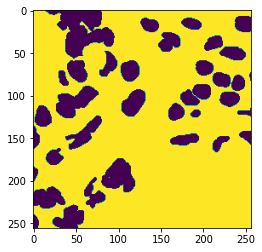

In [48]:
plt.imshow(mask)

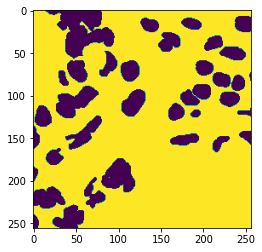

In [51]:
plt.imshow(aug['mask']);

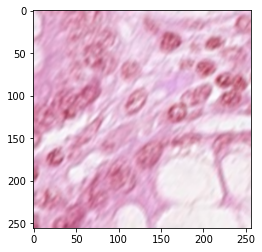

In [50]:
plt.imshow(aug['image']);

In [54]:
aug['mask']

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

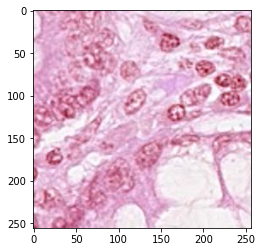

In [52]:
plt.imshow(x)

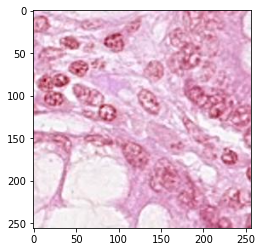

In [36]:
plt.imshow(aug['image'])

TypeError: Invalid shape (256, 3, 256) for image data

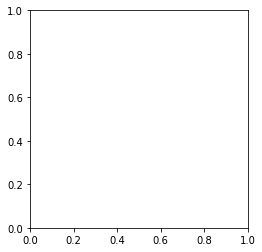

In [33]:
plt.imshow(np.transpose(x, (1,2,0)))

In [4]:
mask.shape

torch.Size([5, 256, 256])

In [5]:
image.shape

torch.Size([3, 256, 256])

In [7]:
img = torch.permute(image, (1,2,0))

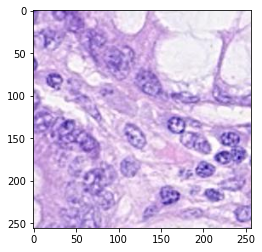

In [9]:
plt.imshow(img.int())

In [22]:
import numpy as np

In [23]:
mask = np.load("/root/autodl-tmp/datasets/consep/inst/train/train_10_000.npy")

In [28]:
mask

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [777, 777, 777, ...,   0,   0,   0],
       [777, 777, 777, ...,   0,   0,   0],
       [777, 777, 777, ...,   0,   0,   0]], dtype=int32)

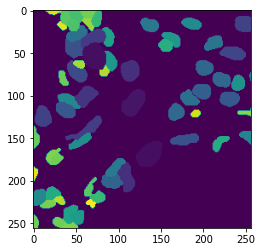

In [25]:
plt.imshow(mask)

TypeError: Invalid shape (3, 256, 256) for image data

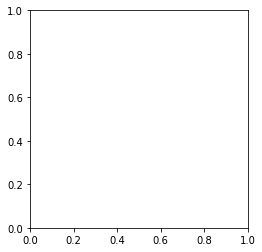

In [10]:
plt.imshow(image)

In [1]:
import os
import wandb
os.environ['WANDB_MODE'] = 'offline'
from argparse import Namespace

def train(config, dataset_name, dir_root, save_dir, model_name='dist'):
    # setting up 
    rm_n_mkdir(save_dir)
    logger = get_logger(log_file_name='train.log', log_dir=save_dir)
    writer_save_dir = os.path.join(f"{save_dir}/tf_logs")
    rm_n_mkdir(writer_save_dir)
    writer = SummaryWriter(writer_save_dir)

    classes = dict()
    classes.update({'pannuke':['Background','Neoplastic','Inflammatory','Connective','Dead','Epithelial']})
    classes.update({'monusac': ['Background','Epithelial','Lymphocyte','Neutrophil','Macrophage']})
    classes.update({'consep': ['background','inflammatory','healthy_epithelial','epithelial', 'spindle-shaped']})
    classes.update({'cpm17':None}) 

    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # build dataloader
    ## train set
    train_images_dir = opj(dir_root, 'images/train')
    train_masks_dir =  opj(dir_root, 'seg_mask/train')
    train_loader = DataLoader(dataset=DISTDataset(train_images_dir, train_masks_dir, classes=classes[dataset_name]),
                              batch_size = config.batch_size,
                              shuffle=True,
                              drop_last=False,
                              num_workers=config.num_workers)
    ## test set
    test_images_dir = opj(dir_root, 'images/test')
    test_masks_dir =  opj(dir_root, 'seg_mask/test')
    test_loader = DataLoader(dataset=DISTDataset(test_images_dir, test_masks_dir, classes=classes[dataset_name]),
                              batch_size = config.batch_size,
                              shuffle=False,
                              drop_last=False,
                              num_workers=config.num_workers)
    # build model
    model = DIST(num_features=cofig.num_features).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    
    # train model
    n_total_steps = len(train_loader)
    for epoch in tqdm(range(config.epochs)):
        start = time.perf_counter() 
        model = model.to(device)
        train_loss = 0
        for iter_idx, (image, label, _) in enumerate(train_loader):
            model.train()
            image, label = image.to(device), label.to(device)
            pred = model(image) 
            loss = loss_fn(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss
        
        # save models every save_interval
        if epoch % config.save_interval == 0:
            save_path = opj(save_dir, "epoch_{}.pth".format(epoch))
            torch.save(model.state_dict(), save_path)

        # save models every val_interval
        n_test_steps = len(test_loader)
        if epoch % config.val_interval == 0:
            loss_item = 0
            for iter_idx, (image, label, img_paths) in enumerate(test_loader):
                model.eval()
                model = model.cpu()
                image, label = image.to('cpu'), label.to('cpu')
                pred = model(image) 
                loss = loss_fn(pred, label)
                loss_item += loss
                
        validation_loss = loss_item
        
        dur = time.perf_counter() - start    
        logger.info("epoch_{} takes {}s".format(epoch, dur))
        
    return train_loss, validation_loss 

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'tune_ts',
    'metric': {'goal': 'minimize', 'name': 'validation_loss'},
    
    'parameters': 
    {
        
        'epochs':{'values':300},
        'val_interval':{'values':1},
        'save_interval':{'values':50},
        'num_workers':{'values':8},
        
        'batch_size': {'values': [2, 4, 8, 16, 32, 64]},
        'lr': {'distribution': 'uniform', 'max': 0.01, 'min': 0.00001},
        'weight_decay':{'distribution': 'uniform', 'max': 0.01, 'min': 0.00001},
        'num_features':{'values':[3, 5, 8, 10, 20, 30, 50, 80, 100]},
     }
    'early_terminate':{'type': 'hyperband', 'min_iter': 3}
}


def main():
    wandb.init(project='dist_consep_tune')
    train_loss, validation_loss = train(wandb.config)
    wandb.log({'train_loss': train_loss,
              'val_loss': validation_loss,
              })
   
sweep_id = wandb.sweep(
  sweep=sweep_configuration, 
  project='dist_consep_tune'
  )

wandb.agent(sweep_id, function=main, count=300)